# TODO Notebook under construction

# Calculation of the loss function for classification


**Goal:** In this notebook you will calculate the loss function using numpy.


**Usage:** Execute the notebook until you reach the position your code here and fill out the blanks. 

**Dataset:** You work with the MNIST dataset. We have 60'000 28x28 pixel greyscale images of digits and want to classify them into the right label (0-9).

**Content:**
* load the original MNIST data 
* Eval the loss function using Keras 
* Implement the loss function yourself using numpy


| [open in colab](https://colab.research.google.com/github/tensorchiefs/dl_book/blob/master/chapter_04/nb_ch04_03.ipynb)



In [1]:
#load required libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')
import numpy as np

import tensorflow as tf

import keras 
from keras.models import Sequential
from keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten , Activation
from keras import optimizers

Using TensorFlow backend.


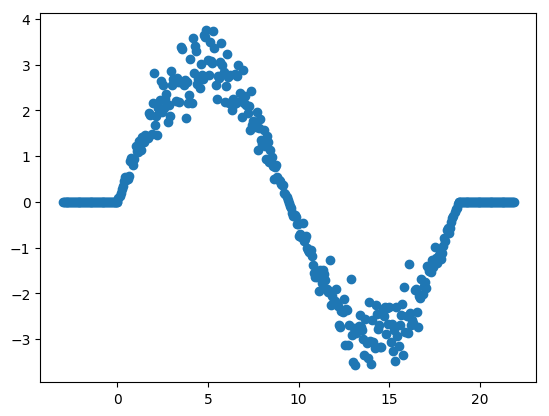

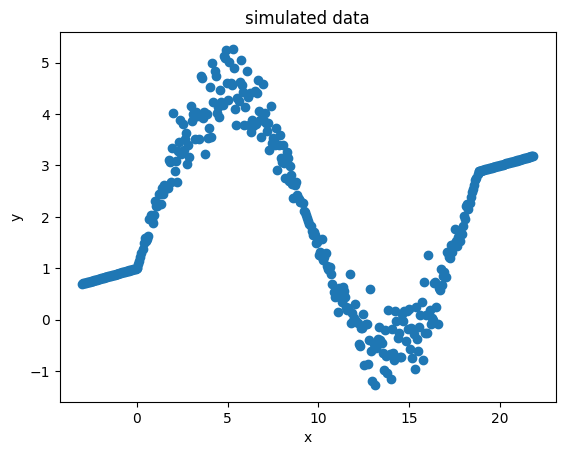

In [17]:
## Simulate some data 
n = 300
np.random.seed(32)
x = np.linspace(0,1*2*np.pi,n)
y1 = 3*np.sin(x)
y1 = np.concatenate((np.zeros(60), y1+np.random.normal(0,0.15*np.abs(y1),n),np.zeros(60)))
x=np.concatenate((np.linspace(-3,0,60),np.linspace(0,3*2*np.pi,n),np.linspace(3*2*np.pi,3*2*np.pi+3,60)))
plt.scatter(x=x,y=y1)
plt.show()
y2 = 0.1*x+1
y=y1+y2
plt.scatter(x=x,y=y)
plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")
n=len(x)

In [0]:
model = Sequential()
model.add(Dense(1, activation='linear',batch_input_shape=(None, 1)))
model.compile(loss='mean_squared_error',optimizer="adam")

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [0]:

# train the model# train  
history=model.fit(x, y, 
                  batch_size=n, 
                  epochs=5000,
                  verbose=0, 
                 )

In [21]:
model.evaluate(x,y)

420/420 [==============================] - 0s 127us/step


2.561912518455869

Text(0, 0.5, 'y')

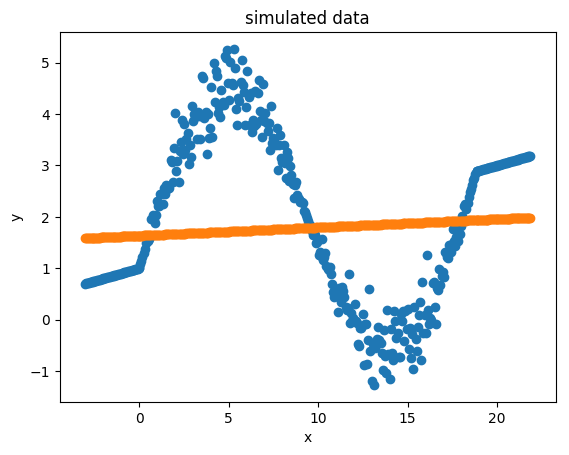

In [22]:
plt.scatter(x=x,y=y)
plt.scatter(x=x,y=model.predict(x))

plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")

In [23]:
model.get_weights()

[array([[0.01611285]], dtype=float32), array([1.6332729], dtype=float32)]

In [0]:
model = Sequential()
model.add(Dense(20, activation='relu',batch_input_shape=(None, 1)))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='linear'))
#
model.compile(loss='mean_squared_error',optimizer="adam")


In [35]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 20)                40        
_________________________________________________________________
dense_16 (Dense)             (None, 50)                1050      
_________________________________________________________________
dense_17 (Dense)             (None, 20)                1020      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 21        
Total params: 2,131
Trainable params: 2,131
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train the model
history=model.fit(x, y, 
                  batch_size=n, 
                  epochs=10000,
                  verbose=0, 
                 )

In [37]:
model.evaluate(x,y)

420/420 [==============================] - 0s 297us/step


0.06719058776091386

Text(0, 0.5, 'y')

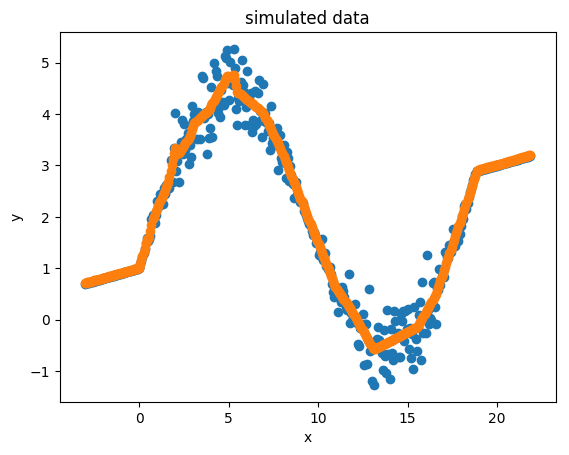

In [38]:
plt.scatter(x=x,y=y)
plt.scatter(x=x,y=model.predict(x))

plt.title("simulated data")
plt.xlabel("x")
plt.ylabel("y")

In [39]:
W=model.get_weights()
W[0]

array([[-0.04985445,  0.43999407, -0.01796524, -0.14448635, -0.15009394,
        -0.4373425 ,  0.49973184, -0.06098714,  0.2509444 , -0.00931787,
         0.20448591,  0.18380572,  0.44206166,  0.4986615 , -0.42914584,
        -0.46341148, -0.01825942,  0.5389306 ,  0.08761758, -0.47259247]],
      dtype=float32)

In [40]:
tf.reset_default_graph() #Just to be sure to start with an empty graph

X = tf.placeholder('float32', shape=[None,1], name='x_data')
Y = tf.placeholder('float32', shape=[None,1], name='y_data')

#W1 = tf.layers.dense(inputs=X,units=50,kernel_initializer= tf.constant_initializer(W[0]) ,bias_initializer=tf.Variable(initial_value=W[1]),activation='relu', name ='W1') 
W1 = tf.layers.dense(inputs=X,units=20,activation='relu', name ='W1') 
W2 = tf.layers.dense(inputs=W1,units=50,activation='relu', name ='W2') 
W3 = tf.layers.dense(inputs=W2,units=20,activation='relu', name ='W3') 

mu = tf.layers.dense(inputs=W3,units=1,activation='linear', name ='mu') 
log_sigma = tf.layers.dense(inputs=W3,units=1,activation='linear', name= 'log_sigma') 

a=1/(tf.sqrt(2*3.141*tf.square(tf.exp(log_sigma))))# 
b1=tf.square(mu-Y)
b2=2*tf.square(tf.exp(log_sigma))
b=b1/b2

loss = tf.reduce_sum(-tf.log(a)+b,axis=0)

#train_op = tf.train.GradientDescentOptimizer(0.00001).minimize(loss)
train_op = tf.train.AdamOptimizer(0.00003).minimize(loss)

init_op = tf.global_variables_initializer() 


Instructions for updating:
Use keras.layers.dense instead.


In [0]:
x=x.reshape(n,1)
y=y.reshape(n,1)

In [42]:
with tf.Session() as sess:
    sess.run(init_op) #Doing the initialization on the concrete realization of the graph
    loss_= sess.run(fetches=(loss), feed_dict={X:x, Y:y})
    print(loss_)

[4182.256]


In [43]:
with tf.Session() as sess:
    sess.run(init_op) #Doing the initialization on the concrete realization of the graph
    for i in range(200000):
        #rand_index = np.random.choice(n, size=32)
        #x_batch = x[rand_index]
        #y_batch = y[rand_index]
        #loss_,_, = sess.run(fetches=(loss,train_op), feed_dict={X:x_batch, Y:y_batch})
        loss_,_,pred_mu,pred_log_sigma = sess.run(fetches=(loss,train_op,mu,log_sigma), feed_dict={X:x, Y:y})
        if (i % 20000 == 0):
            print("i={} loss={}".format(i,loss_))        
    #loss_,_,pred_mu,pred_log_sigma = sess.run(fetches=(loss,train_op,mu,log_sigma), feed_dict={X:x, Y:y})
    print("i={} loss={}".format(i,loss_))

i=0 loss=[2784.1025]
i=20000 loss=[-317.12042]
i=40000 loss=[-504.2833]
i=60000 loss=[-775.56903]
i=80000 loss=[-796.1052]
i=100000 loss=[-823.9323]
i=120000 loss=[-753.9666]
i=140000 loss=[-842.1429]
i=160000 loss=[-635.12604]
i=180000 loss=[-540.714]
i=199999 loss=[-858.9415]


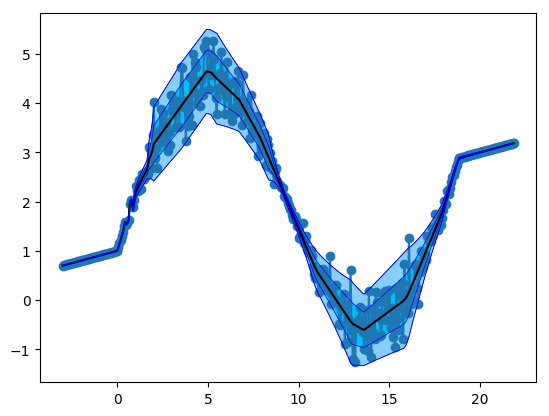

In [44]:
plt.plot(x,y[:,0],marker='o')

plt.plot(x,pred_mu[:,0],c="black")

pred_1_sd_p = pred_mu[:,0]+(np.exp(pred_log_sigma[:,0]))
pred_1_sd_m = pred_mu[:,0]-(np.exp(pred_log_sigma[:,0]))

plt.plot(x,pred_1_sd_p, 'b', linewidth=0.5)
plt.plot(x,pred_1_sd_m, 'b', linewidth=0.5)

pred_2_sd_p = pred_mu[:,0]+2*(np.exp(pred_log_sigma[:,0]))
pred_2_sd_m = pred_mu[:,0]-2*(np.exp(pred_log_sigma[:,0]))

plt.plot(x,pred_2_sd_p, 'b', linewidth=0.5)
plt.plot(x,pred_2_sd_m, 'b', linewidth=0.5)


plt.plot(x,pred_mu[:,0]+2*(np.exp(pred_log_sigma[:,0])), 'b', linewidth=0.5)
plt.plot(x,pred_mu[:,0]-2*(np.exp(pred_log_sigma[:,0])), 'b', linewidth=0.5)

plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([pred_2_sd_p,
                         pred_2_sd_m[::-1]]),alpha=1, fc='lightskyblue', ec='None')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([pred_1_sd_p,
                         pred_1_sd_m[::-1]]),alpha=1, fc='deepskyblue', ec='None')
plt.show()
